## Calculate the effect of the scene graph solver

the scene nodes are ordered, so the edge difference can be directly used to measure the difference between naively pick
the most probable edge or taking the whole graph into consideration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import networkx as nx
import matplotlib.pyplot as plt
import h5py


In [32]:
scenes_edge = read_json('G:/My Drive/Research/data/scenes/scenes_with_rels.json')
scenes_graph = read_json('G:/My Drive/Research/data/scenes/scenes_with_rels_corrected.json')


In [4]:
directions = ['left', 'right', 'behind', 'front']
differences = {i: {'more': [], 'few': []} for i in range(len(scenes_graph['scenes']))}

for i, (scene_graph, scene_edge) in enumerate(zip(scenes_edge['scenes'], scenes_graph['scenes'])):
    for dire in directions:
        for source, (targets_graph, targets_edge) in enumerate(zip(scene_graph['relationships'][dire],
                                                                   scene_edge['relationships'][dire])):
            targets_graph = set(targets_graph)
            targets_edge = set(targets_edge)

            more = [(source, target, dire) for target in targets_graph.difference(targets_edge)]
            few = [(source, target, dire) for target in targets_edge.difference(targets_graph)]
            differences[i]['more'].extend(more)
            differences[i]['few'].extend(few)

differences = {key : value for (key, value) in differences.items() if len(value['more']) > 0 or len(value['few']) > 0}



In [5]:
for scene_id in differences.keys():
    print(scene_id)
    for direction in directions:
        graph = convert_to_nx(scenes_edge['scenes'][scene_id], [direction], ['r'])
        print(f'{direction} {list(nx.simple_cycles(graph))}')

19
left [[8, 1]]
right []
behind []
front []
82
left []
right []
behind []
front [[8, 7]]
226
left [[8, 6]]
right []
behind []
front []
230
left []
right []
behind []
front [[4, 5]]
233
left []
right [[4, 5]]
behind []
front []
234
left []
right []
behind [[4, 6]]
front []
273
left [[0, 9]]
right []
behind []
front []
339
left []
right [[3, 6]]
behind []
front []
356
left [[0, 5]]
right []
behind []
front []
417
left []
right []
behind []
front [[8, 2]]
440
left []
right []
behind []
front [[8, 7]]
441
left []
right []
behind []
front [[4, 6]]
472
left []
right []
behind [[8, 7]]
front []
474
left []
right []
behind [[4, 7]]
front []
501
left []
right [[1, 6]]
behind [[9, 4]]
front []
597
left []
right []
behind [[3, 5]]
front []
694
left []
right []
behind []
front [[2, 7]]
753
left []
right []
behind []
front [[8, 4]]
797
left []
right []
behind [[0, 7]]
front []
841
left []
right []
behind [[0, 4]]
front []
853
left []
right []
behind []
front [[0, 6]]


In [6]:
differences

{19: {'more': [(1, 8, 'left')], 'few': [(1, 8, 'right')]},
 82: {'more': [(8, 7, 'front')], 'few': [(8, 7, 'behind')]},
 226: {'more': [(8, 6, 'left')], 'few': [(8, 6, 'right')]},
 230: {'more': [(4, 5, 'front')], 'few': [(4, 5, 'behind')]},
 233: {'more': [(5, 4, 'right')], 'few': [(5, 4, 'left')]},
 234: {'more': [(4, 6, 'behind')], 'few': [(4, 6, 'front')]},
 273: {'more': [(0, 9, 'left')], 'few': [(0, 9, 'right')]},
 339: {'more': [(3, 6, 'right')], 'few': [(3, 6, 'left')]},
 356: {'more': [(0, 5, 'left')], 'few': [(0, 5, 'right')]},
 417: {'more': [(8, 2, 'front')], 'few': [(8, 2, 'behind')]},
 440: {'more': [(7, 8, 'front')], 'few': [(7, 8, 'behind')]},
 441: {'more': [(4, 6, 'front')], 'few': [(4, 6, 'behind')]},
 472: {'more': [(8, 7, 'behind')], 'few': [(8, 7, 'front')]},
 474: {'more': [(7, 4, 'behind')], 'few': [(7, 4, 'front')]},
 501: {'more': [(6, 1, 'right'), (4, 9, 'behind')],
  'few': [(6, 1, 'left'), (4, 9, 'front')]},
 597: {'more': [(3, 5, 'behind')], 'few': [(3, 5,

In [7]:
    # pos = nx.circular_layout(graph)
    # edges = graph.edges()
    #
    # colors = []
    # for u, v, data in list(graph.edges(data=True)):
    #     colors.append(data['color'])

# Fault Case Analysis

In [29]:
vocab = read_json('G:/My Drive/Research/data/vocab.json')
clevr_results = read_json('G:/My Drive/Research/data/reason/results/result_clevr.json')
clevr_rel_corrected_results = read_json('G:/My Drive/Research/data/reason/results/result_clevr_corrected.json')
questions = read_json('G:/My Drive/Research/data/Original/CLEVR_questions.json')['questions']
h5_filename = 'G:/My Drive/Research/data/Original/images.h5'
images = h5py.File(h5_filename, 'r')['images']

In [9]:
wrong_ans_indexes = [i for (i, correct) in enumerate(clevr_results['corrects']) if not correct]
wrong_ans_indexes_rel_corrected = [i for (i, correct) in enumerate(clevr_rel_corrected_results['corrects']) if not correct]


In [12]:
i = 6696
print(i)
print(questions[i]['question'])
print(scenes_graph['scenes'][questions[i]['image_index']])
print(len(scenes_graph['scenes'][questions[i]['image_index']]['objects']))
plt.imshow(images[questions[i]['image_index']])
print(f"Model Answer: {clevr_rel_corrected_results['answers'][i]}")
print(f"Actual Result: {questions[i]['answer']}")
[vocab['program_idx_to_token'][str(i)] for i in clevr_results['programs'][i]]

6696


NameError: name 'questions' is not defined

## Check If the faults are repairable
1. The correct answer is ranked second, after the prediction
2. The correct answer is higher than all other objects in the scene without that property

In [3]:
import pandas as pd

In [35]:
error_df = pd.read_csv('G:/My Drive/Research/data/measurements/error_cases.csv')
scenes = read_json('G:/My Drive/Research/data/scenes/scenes_proba.json')['scenes']
attr_map = read_json('G:/My Drive/Research/data/clevr_attr_map.json')['attributes']
attributes = ['size', 'color', 'material', 'shape']

In [51]:
for _, row in error_df.iterrows():
    print(row['image_id'])
    scene = scenes[row['image_id']]
    attr_name = row['attr_name']
    objects = scene['objects']

    target_obj = find_matching_object(row['detected_object'], objects, attr_map, attributes)
    if not target_obj:
        print('did not find matching object')
        continue

    print(row['attr_name'])
    actual_idx = attr_map[attr_name].index(row['actual'])
    actual_proba = target_obj[attr_name][actual_idx]
    sorted_dist = np.argsort(target_obj[attr_name])
    print(f'gt prob? {target_obj[attr_name][actual_idx]}')
    print(f'gt is the second best? {sorted_dist[-2] == actual_idx}')

    more_significant = is_more_significant(target_obj, objects, attr_name, actual_idx)
    print(f'gt is more significant? {more_significant}')


184
color
gt prob? 0.005968824028968811
gt is the second best? True
gt is more significant? True
207
size
gt prob? 0.3000764846801758
gt is the second best? True
gt is more significant? True
226
shape
gt prob? 0.015813350677490234
gt is the second best? True
gt is more significant? True
265
shape
gt prob? 0.003326356876641512
gt is the second best? True
gt is more significant? True
329
shape
gt prob? 5.954895186732756e-06
gt is the second best? True
gt is more significant? False
444
shape
gt prob? 0.41011369228363037
gt is the second best? True
gt is more significant? True
592
shape
gt prob? 0.42855921387672424
gt is the second best? True
gt is more significant? True
641
shape
gt prob? 0.008016800507903099
gt is the second best? True
gt is more significant? True
669
shape
gt prob? 0.36291930079460144
gt is the second best? True
gt is more significant? True
697
color
gt prob? 0.02594890631735325
gt is the second best? True
gt is more significant? True
739
shape
gt prob? 0.00011164064926

In [12]:
error_df

,image_id,detected_object,attr_name,predicted,actual
0,184,small gray rubber cube,color,gray,blue
1,207,small yellow ruber sphere,size,small,large
2,226,small cyan metal cylinder,shape,cylinder,cube
3,265,small cyan rubber sphere,shape,sphere,cylinder
4,329,small green rubber cylinder,shape,cylinder,sphere
5,444,small gray metal cylinder,shape,cylinder,cube
6,592,small blue rubber cube,shape,cylinder,cube
7,641,small blue metal sphere,shape,sphere,cube
8,669,small gray metal sphere,shape,shpere,cube
9,697,large red metal cube,color,red,purple


# Graph Edit Distance metrics

In [29]:
from scene_graph_transformer import get_concrete_scene_graph, get_simple_concrete_attributes
from utils import dag_constraint, anti_symmetry_constraint, construct_adj
from tqdm import tqdm

In [78]:
scenes = read_json('../results/carla_test_50p/rel_scenes.json')['scenes']
gt_scenes = read_json('../data/carla/scenes_test_50p.json')['scenes']
schema = read_json('../data/carla/schema.json')#read_json('G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')
con_scenes = read_json('../results/carla_test_50p/rel_scenes_consistent.json')['scenes']

In [79]:
concrete_scenes = [get_concrete_scene_graph(scene, schema) for scene in scenes]
gt_scenes = [process_gt_scenes(scene, schema) for scene in gt_scenes]
for scene in con_scenes:
    scene['objects'] = get_simple_concrete_attributes(scene, schema)

In [9]:
error_maps = error_classification_for_scenes(con_scenes, gt_scenes, schema['relations'])

# count = 0
# num_nodes = []
# for scene, gt_scene in zip(con_scenes, gt_scenes):
#     graph, gt_graph = convert_to_nx_di(scene, schema['relations']), convert_to_nx_di(gt_scene, schema['relations'])
#     if len(graph.nodes) != len(gt_graph.nodes):
#         num_nodes.append(len(graph.nodes))
#         count += 1
#
# print(count)

100%|██████████| 1000/1000 [00:02<00:00, 379.95it/s]


In [10]:
len(error_maps)

19

In [20]:
nx.adjacency_matrix(graph).todense()

matrix([[0, 2, 2, 2, 2, 2, 2, 2],
        [2, 0, 2, 2, 2, 2, 2, 2],
        [2, 2, 0, 2, 2, 2, 2, 2],
        [2, 2, 2, 0, 2, 2, 2, 2],
        [2, 2, 2, 2, 0, 2, 2, 2],
        [2, 2, 2, 2, 2, 0, 2, 2],
        [2, 2, 2, 2, 2, 2, 0, 2],
        [2, 2, 2, 2, 2, 2, 2, 0]], dtype=int32)

In [35]:
concrete_scenes[0]['relationships'].keys()

dict_keys(['left', 'right', 'front', 'behind'])

In [89]:
# graph = convert_to_nx(concrete_scenes[0], schema['relations'])
errors = []
for scene in concrete_scenes:
    adj = construct_adj(scene['relationships'], len(scene['objects']))
    errors.append((dag_constraint(adj), anti_symmetry_constraint(adj)))


(array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

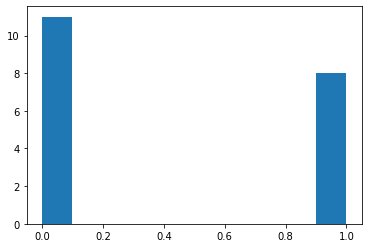

In [81]:
plt.hist([len(e['attribute_errors']) for e in error_maps])

(array([1.955e+03, 9.300e+01, 2.300e+01, 1.000e+01, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  10.3,  20.6,  30.9,  41.2,  51.5,  61.8,  72.1,  82.4,
         92.7, 103. ]),
 <BarContainer object of 10 artists>)

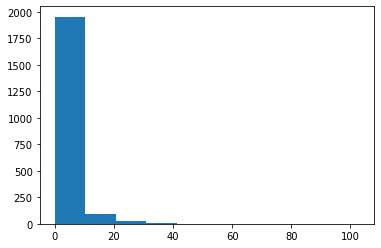

In [90]:
plt.hist([e[1] for e in errors])

In [ ]:
error_maps = error_classification_for_scenes(con_scenes, gt_scenes, schema['relations'])

In [58]:
len(error_maps)


1535

Check Original Scenes

In [66]:
import h5py
import matplotlib.pyplot as plt
import cv2

In [64]:
images = h5py.File('G:/My Drive/Research/data/Original/images.h5')['images']

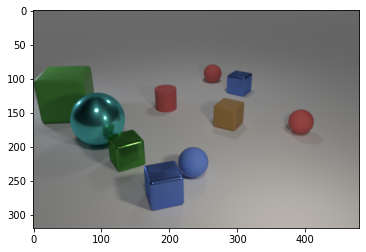

In [65]:
plt.imshow(images[171])

In [77]:
for i, image in tqdm(enumerate(images)):
    cv2.imwrite(f'G:/My Drive/Research/data/Original/images/CLEVR_new_{i:06}.png', image)


1000it [00:23, 41.71it/s]
